In [33]:
options(repos = c(CRAN = "https://cloud.r-project.org"))

if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2, dplyr, lubridate, stringr, readxl, data.table, gdata, scales, data.table)

In [34]:
data.2010 <- read.csv('../data/data-2010.csv')
data.2011 <- read.csv('../data/data-2011.csv')
data.2012 <- read.csv('../data/data-2012.csv')
data.2013 <- read.csv('../data/data-2013.csv')
data.2014 <- read.csv('../data/data-2014.csv')
data.2015 <- read.csv('../data/data-2015.csv')

In [35]:
fix_type <- function(df) {
  df$org_parent <- as.character(df$org_parent)
  df
}

data.2011 <- fix_type(data.2011)

In [36]:
data.full <- bind_rows(data.2010, data.2011, data.2012, data.2013, data.2014, data.2015)  %>%
  mutate(market_share = avg_enrollment / avg_enrolled)

# Problem 1

In [37]:
summary_table <- data.full %>%
  group_by(year) %>%
  summarise(
    'Average Star Rating' = round(mean(Star_Rating, na.rm = TRUE), 2),
    'Average Enrollments' = round(mean(avg_enrollment, na.rm = TRUE), 2),
    'Average Market Share' = round(mean(market_share, na.rm = TRUE), 4),
    'Total Number Of Plans' = n()
  )

print(summary_table)

# A tibble: 6 × 5
   year `Average Star Rating` `Average Enrollments` `Average Market Share`
  <int>                 <dbl>                 <dbl>                  <dbl>
1  2010                  2.97                  256.                 0.0658
2  2011                  3.26                  343.                 0.0855
3  2012                  3.36                  377.                 0.0856
4  2013                  3.55                  396.                 0.0815
5  2014                  3.81                  437.                 0.08  
6  2015                  3.96                  470.                 0.0787
# ℹ 1 more variable: `Total Number Of Plans` <int>


## Problem 2

In [38]:
without_rating_table <- data.full %>%
  filter(is.na(Star_Rating)) %>%
  group_by(year) %>%
  summarise(
    'Average Enrollments' = round(mean(avg_enrollment, na.rm = TRUE), 2),
    'Average Market Share' = round(mean(market_share, na.rm = TRUE), 4),
    'Total Number Of Plans' = n()
  )

print(without_rating_table)

# A tibble: 6 × 4
   year `Average Enrollments` `Average Market Share` `Total Number Of Plans`
  <int>                 <dbl>                  <dbl>                   <int>
1  2010                  107.                 0.0673                   48643
2  2011                  168.                 0.09                     12754
3  2012                  173.                 0.0567                    9077
4  2013                  214.                 0.06                      3661
5  2014                  258.                 0.0557                    3708
6  2015                  314.                 0.0405                    4680


## Problem 3

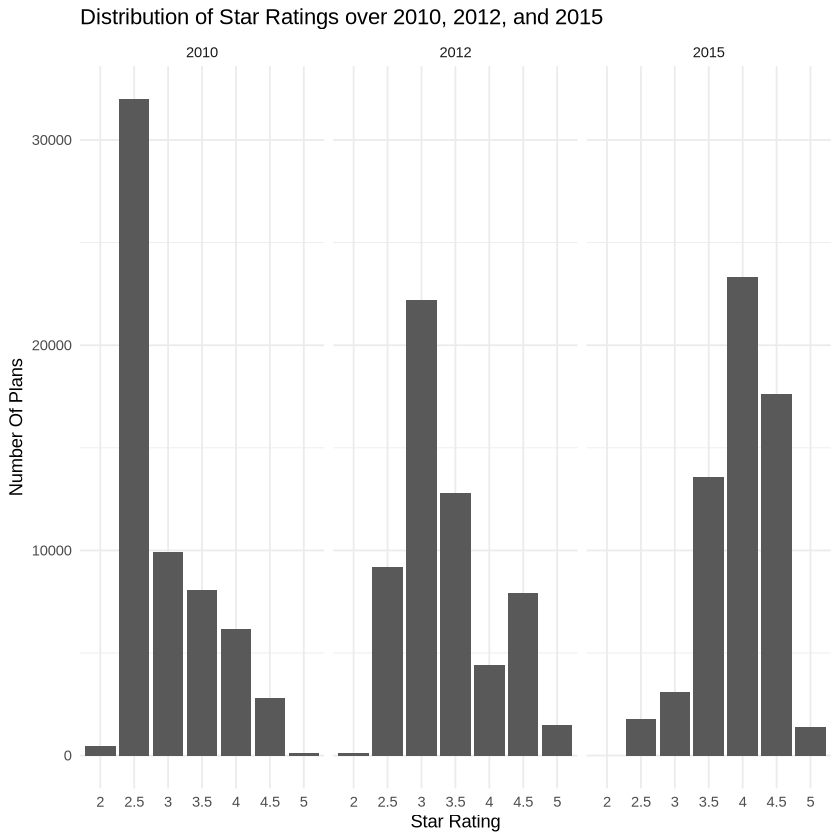

In [39]:
data.full %>%
  filter(year %in% c(2010, 2012, 2015), !is.na(Star_Rating)) %>%
  mutate(year = as.factor(year)) %>%
  ggplot(aes(x = as.factor(Star_Rating))) +
  geom_bar() +
  facet_wrap(~ year) +
  labs(
    title = "Distribution of Star Ratings over 2010, 2012, and 2015",
    x = "Star Rating",
    y = "Number Of Plans"
  ) +
  theme_minimal()

We note that the there is steep decrease in the number of high-rated plans in 2010, whereas in 2012 the difference is less stark, and in 2015, we notice an improvement, with existence of a larger number of high-rated plans.

## Problem 4

In [40]:
data.full <- data.full %>%
  mutate(
    star_3   = as.integer(Star_Rating == 3),
    star_35  = as.integer(Star_Rating == 3.5),
    star_4   = as.integer(Star_Rating == 4),
    star_45  = as.integer(Star_Rating >= 4.5)
  )

estimate <- list()

for(yr in 2010:2015){
  ols <- lm(market_share ~ star_3 + star_35 + star_4 + star_45, 
            data = data.full %>% filter(year == yr, !is.na(Star_Rating), !is.na(market_share)))
  estimate[[as.character(yr)]] <- coef(ols)
}

ols_table <- as.data.frame(estimate)
colnames(ols_table) <- c("2010", "2011", "2012", "2013", "2014", "2015")
rownames(ols_table) <- c("Excluded (<= 2.5 stars)", "3 Stars", "3.5 Stars", "4 Stars", ">= 4.5 Stars")

print(round(ols_table, 4))

                           2010    2011    2012   2013   2014   2015
Excluded (<= 2.5 stars)  0.0634  0.0702  0.0789 0.0491 0.0640 0.0606
3 Stars                  0.0126  0.0350  0.0307 0.0621 0.0267 0.0271
3.5 Stars                0.0005  0.0191  0.0129 0.0385 0.0273 0.0388
4 Stars                 -0.0036  0.0028 -0.0246 0.0172 0.0074 0.0115
>= 4.5 Stars            -0.0076 -0.0095 -0.0134 0.0222 0.0071 0.0233


## Problem 5

In [41]:
quality_vars <- c(
  "breastcancer_screen",
  "rectalcancer_screen",
  "cv_diab_cholscreen",
  "glaucoma_test",
  "monitoring",
  "flu_vaccine",
  "pn_vaccine",
  "physical_health",
  "mental_health",
  "osteo_test",
  "physical_monitor",
  "primaryaccess",
  "osteo_manage",
  "diab_healthy",
  "bloodpressure",
  "ra_manage",
  "copd_test",
  "bladder",
  "falling",
  "nodelays",
  "doctor_communicate",
  "carequickly",
  "customer_service",
  "overallrating_care",
  "overallrating_plan",
  "complaints_plan",
  "appeals_timely",
  "appeals_review",
  "leave_plan",
  "audit_problems",
  "hold_times",
  "info_accuracy",
  "ttyt_available"
)

library(dplyr)

data.2010 <- data.2010 %>%
  rowwise() %>%
  mutate(
    raw_rating = mean(c_across(all_of(quality_vars)), na.rm = TRUE)
  ) %>%
  ungroup()

In [42]:
round_up_counts <- data.2010 %>%
  filter(!is.na(raw_rating)) %>%
  filter(!is.na(partc_score)) %>%
  mutate(
    round_ups = case_when(
      raw_rating >= 2.75 & partc_score == 3.0  ~ "Rounded up to 3",
      raw_rating >= 3.25 & partc_score == 3.5  ~ "Rounded up to 3.5",
      raw_rating >= 3.75 & partc_score == 4.0  ~ "Rounded up to 4",
      raw_rating >= 4.25 & partc_score == 4.5  ~ "Rounded up to 4.5",
      raw_rating >= 4.75 & partc_score == 5.0  ~ "Rounded up to 5",
      TRUE ~ NA_character_
    )
  ) %>%
  filter(!is.na(round_ups)) %>%
  count(round_ups) %>%
  rename('Star Rating' = round_ups, 'Corresponding Number Of Plans' = n)

print(round_up_counts)

# A tibble: 5 × 2
  `Star Rating`     `Corresponding Number Of Plans`
  <chr>                                       <int>
1 Rounded up to 3                              9918
2 Rounded up to 3.5                            8091
3 Rounded up to 4                              4284
4 Rounded up to 4.5                             771
5 Rounded up to 5                                30


## Problem 6

In [43]:
ma_25star_candidates <- data.2010 %>%
  filter(
    !is.na(raw_rating),
    !is.na(partc_score),
    Star_Rating %in% c(2.5, 3)
  )

n_candidates_total <- nrow(ma_25star_candidates)
n_candidates_by_score <- ma_25star_candidates %>% count(partc_score)

ma_25star <- ma_25star_candidates %>%
  filter(
    raw_rating >= 2.5,
    raw_rating <= 3,
    (raw_rating >= 2.75 & Star_Rating == 3) | (raw_rating < 2.75 & Star_Rating == 2.5)
  )

ma.rd1 <- ma_25star %>%
  mutate(market_share = avg_enrollment / avg_enrolled,
         score = raw_rating - 2.75,
         treat = (score>=0),
         window = (score>=-.125 & score<=.125),
         score_treat=score*treat)

library(rdrobust)

star25.1 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd1 %>% filter(window==TRUE)))
est1 <- as.numeric(star25.1$coef[3])

In [44]:
ma_25star_candidates <- data.2010 %>%
  filter(
    !is.na(raw_rating),
    !is.na(partc_score),
    Star_Rating %in% c(3, 3.5)
  )

n_candidates_total <- nrow(ma_25star_candidates)
n_candidates_by_score <- ma_25star_candidates %>% count(partc_score)

ma_25star <- ma_25star_candidates %>%
  filter(
    raw_rating >= 3,
    raw_rating <= 3.5,
    (raw_rating >= 3.25 & Star_Rating == 3.5) | (raw_rating < 3.25 & Star_Rating == 3)
  )

ma.rd2 <- ma_25star %>%
  mutate(market_share = avg_enrollment / avg_enrolled,
         score = raw_rating - 3.25,
         treat = (score>=0),
         window = (score>=-.125 & score<=.125),
         score_treat=score*treat)

library(rdrobust)

star25.2 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd2 %>% filter(window==TRUE)))
est2 <- as.numeric(star25.2$coef[3])

In [45]:
# our two estimates
est1 <- as.numeric(star25.1$coef[3])
est2 <- as.numeric(star25.2$coef[3])

comparison_table <- data.frame(row.names = c("RD Estimate"), `3 vs 3.5` = est1, `2.5 vs 3` = est2 )

print(comparison_table)

            X3.vs.3.5   X2.5.vs.3
RD Estimate 0.0546005 -0.03953024


## Problem 7

In [46]:
ma_25star_candidates <- data.2010 %>%
  filter(
    !is.na(raw_rating),
    !is.na(partc_score),
    Star_Rating %in% c(2.5, 3)
  )

n_candidates_total <- nrow(ma_25star_candidates)
n_candidates_by_score <- ma_25star_candidates %>% count(partc_score)

ma_25star <- ma_25star_candidates %>%
  filter(
    raw_rating >= 2.5,
    raw_rating <= 3,
    (raw_rating >= 2.75 & Star_Rating == 3) | (raw_rating < 2.75 & Star_Rating == 2.5)
  )

ma.rd1 <- ma_25star %>%
  mutate(market_share = avg_enrollment / avg_enrolled,
         score = raw_rating - 2.75,
         treat = (score>=0),
         window1 = (score>=-.1 & score<=.1),
         window2 = (score>=-.12 & score<=.12),
         window3 = (score>=-.13 & score<=.13),
         window4 = (score>=-.14 & score<=.14),
         window5 = (score>=-.15 & score<=.15),
         score_treat=score*treat)

library(rdrobust)

star25.1 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd1 %>% filter(window1==TRUE)))
star25.2 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd1 %>% filter(window2==TRUE)))
star25.3 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd1 %>% filter(window3==TRUE)))
star25.4 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd1 %>% filter(window4==TRUE)))
star25.5 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd1 %>% filter(window5==TRUE)))
est1 <- as.numeric(star25.1$coef[3])
est2 <- as.numeric(star25.2$coef[3])
est3 <- as.numeric(star25.3$coef[3])
est4 <- as.numeric(star25.4$coef[3])
est5 <- as.numeric(star25.5$coef[3])

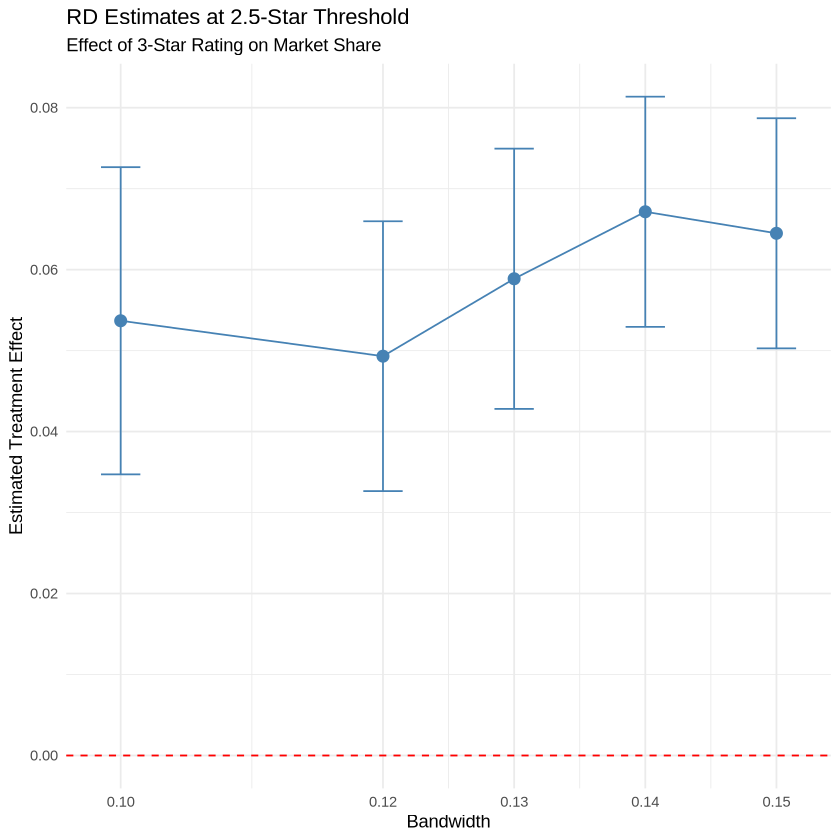

In [47]:
library(ggplot2)

# Create a dataframe of estimates and bandwidths
rd_results <- data.frame(
  bandwidth = c(0.10, 0.12, 0.13, 0.14, 0.15),
  estimate  = c(est1, est2, est3, est4, est5)
)

# Add confidence intervals
se_list <- c(
  summary(star25.1)$coef[3, 2],
  summary(star25.2)$coef[3, 2],
  summary(star25.3)$coef[3, 2],
  summary(star25.4)$coef[3, 2],
  summary(star25.5)$coef[3, 2]
)

rd_results <- rd_results %>%
  mutate(
    se    = se_list,
    ci_lo = estimate - 1.96 * se,
    ci_hi = estimate + 1.96 * se
  )

# Plot
ggplot(rd_results, aes(x = bandwidth, y = estimate)) +
  geom_point(size = 3, color = "steelblue") +
  geom_line(color = "steelblue") +
  geom_errorbar(aes(ymin = ci_lo, ymax = ci_hi), width = 0.003, color = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  scale_x_continuous(breaks = rd_results$bandwidth) +
  labs(
    title    = "RD Estimates at 2.5-Star Threshold",
    subtitle = "Effect of 3-Star Rating on Market Share",
    x        = "Bandwidth",
    y        = "Estimated Treatment Effect"
  ) +
  theme_minimal()

In [48]:
ma_25star_candidates <- data.2010 %>%
  filter(
    !is.na(raw_rating),
    !is.na(partc_score),
    Star_Rating %in% c(3, 3.5)
  )

n_candidates_total <- nrow(ma_25star_candidates)
n_candidates_by_score <- ma_25star_candidates %>% count(partc_score)

ma_25star <- ma_25star_candidates %>%
  filter(
    raw_rating >= 3,
    raw_rating <= 3.5,
    (raw_rating >= 3.25 & Star_Rating == 3.5) | (raw_rating < 3.25 & Star_Rating == 3)
  )

ma.rd2 <- ma_25star %>%
  mutate(market_share = avg_enrollment / avg_enrolled,
         score = raw_rating - 3.25,
         treat = (score>=0),
         window1 = (score>=-.1 & score<=.1),
         window2 = (score>=-.12 & score<=.12),
         window3 = (score>=-.13 & score<=.13),
         window4 = (score>=-.14 & score<=.14),
         window5 = (score>=-.15 & score<=.15),
         score_treat=score*treat)

library(rdrobust)

star25.1 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd2 %>% filter(window1==TRUE)))
star25.2 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd2 %>% filter(window2==TRUE)))
star25.3 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd2 %>% filter(window3==TRUE)))
star25.4 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd2 %>% filter(window4==TRUE)))
star25.5 <- lm(market_share ~ score + treat + score_treat, data= (ma.rd2 %>% filter(window5==TRUE)))
est1 <- as.numeric(star25.1$coef[3])
est2 <- as.numeric(star25.2$coef[3])
est3 <- as.numeric(star25.3$coef[3])
est4 <- as.numeric(star25.4$coef[3])
est5 <- as.numeric(star25.5$coef[3])

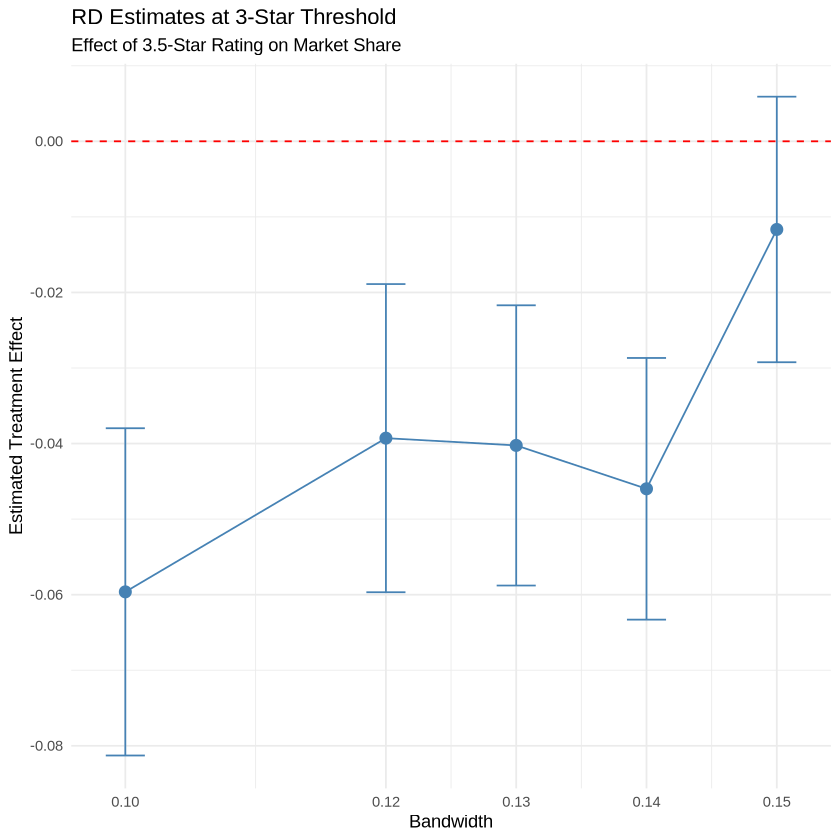

In [49]:
library(ggplot2)

# Create a dataframe of estimates and bandwidths
rd_results <- data.frame(
  bandwidth = c(0.10, 0.12, 0.13, 0.14, 0.15),
  estimate  = c(est1, est2, est3, est4, est5)
)

# Add confidence intervals
se_list <- c(
  summary(star25.1)$coef[3, 2],
  summary(star25.2)$coef[3, 2],
  summary(star25.3)$coef[3, 2],
  summary(star25.4)$coef[3, 2],
  summary(star25.5)$coef[3, 2]
)

rd_results <- rd_results %>%
  mutate(
    se    = se_list,
    ci_lo = estimate - 1.96 * se,
    ci_hi = estimate + 1.96 * se
  )

# Plot
ggplot(rd_results, aes(x = bandwidth, y = estimate)) +
  geom_point(size = 3, color = "steelblue") +
  geom_line(color = "steelblue") +
  geom_errorbar(aes(ymin = ci_lo, ymax = ci_hi), width = 0.003, color = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  scale_x_continuous(breaks = rd_results$bandwidth) +
  labs(
    title    = "RD Estimates at 3-Star Threshold",
    subtitle = "Effect of 3.5-Star Rating on Market Share",
    x        = "Bandwidth",
    y        = "Estimated Treatment Effect"
  ) +
  theme_minimal()

We note that findings are indeed sensitive to bandwidth choice. For instance, the treatment effect in comparing in 3 versus 3.5 star plans appear to be more vivid when compared at the threshold of 0.1 as opposed to 0.15. Similarly, we see a difference in calculated effect when a bandwidth of 0.12 is chosen as opposed to 0.14 while comparsing 2.5 star plans versus 3 star plans.

## Problem 8

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 15955 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 15955 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3641 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3641 rows containing missing values (`geom_point()`).”


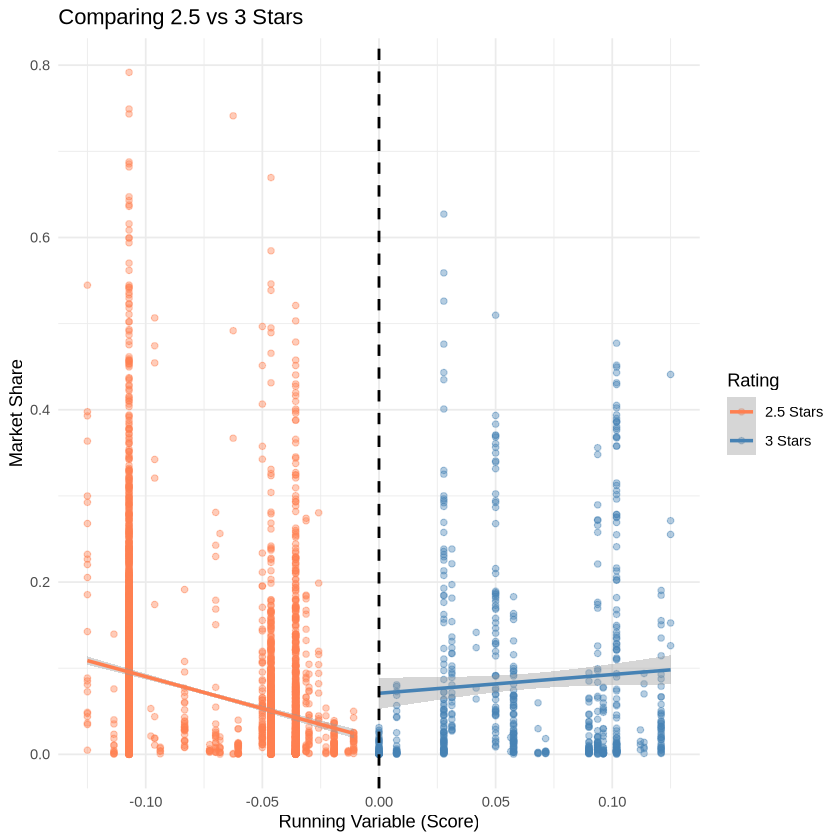

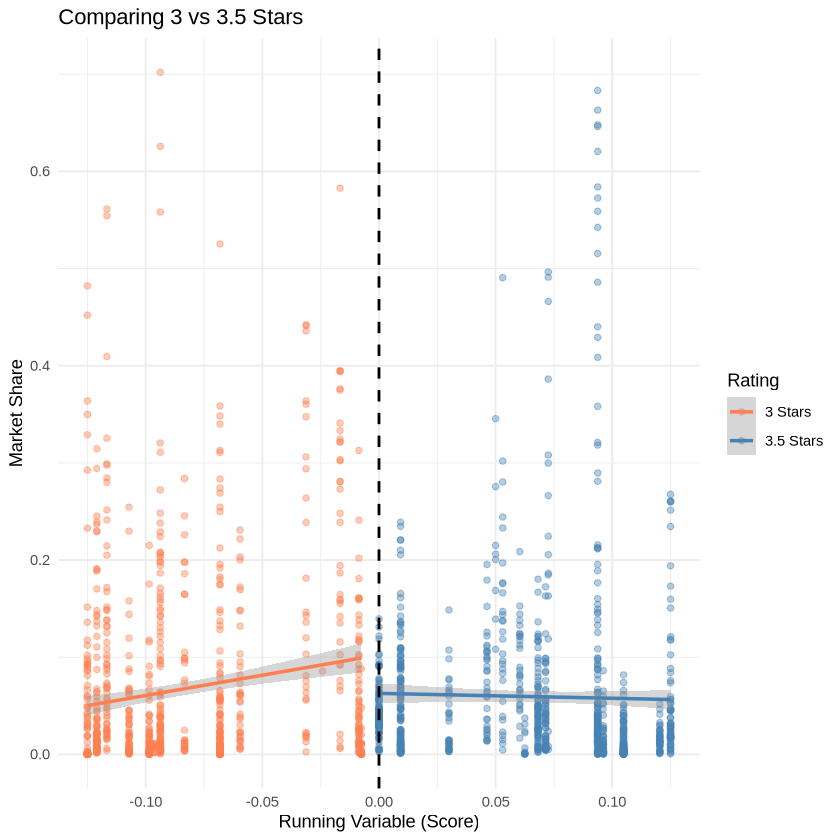

In [62]:
ma_25star_candidates <- data.2010 %>%
  filter(
    !is.na(raw_rating),
    !is.na(partc_score),
    Star_Rating %in% c(2.5, 3)
  )

n_candidates_total <- nrow(ma_25star_candidates)
n_candidates_by_score <- ma_25star_candidates %>% count(partc_score)

ma_25star <- ma_25star_candidates %>%
  filter(
    raw_rating >= 2.5,
    raw_rating <= 3,
    (raw_rating >= 2.75 & Star_Rating == 3) | (raw_rating < 2.75 & Star_Rating == 2.5)
  )

ma.rd1 <- ma_25star %>%
  mutate(market_share = avg_enrollment / avg_enrolled,
         score = raw_rating - 2.75,
         treat = (score>=0),
         window = (score>=-.125 & score<=.125),
         score_treat=score*treat)

p1 <- ggplot(ma.rd1 %>% filter(window == TRUE), 
             aes(x = score, y = market_share, color = treat)) +
  geom_point(alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", linewidth = 0.8) +
  scale_color_manual(values = c("FALSE" = "coral", "TRUE" = "steelblue"),
                     labels = c("2.5 Stars", "3 Stars")) +
  labs(title = "Comparing 2.5 vs 3 Stars", x = "Running Variable (Score)",
       y = "Market Share", color = "Rating") +
  theme_minimal()

ma_25star_candidates <- data.2010 %>%
  filter(
    !is.na(raw_rating),
    !is.na(partc_score),
    Star_Rating %in% c(3, 3.5)
  )

n_candidates_total <- nrow(ma_25star_candidates)
n_candidates_by_score <- ma_25star_candidates %>% count(partc_score)

ma_25star <- ma_25star_candidates %>%
  filter(
    raw_rating >= 3,
    raw_rating <= 3.5,
    (raw_rating >= 3.25 & Star_Rating == 3.5) | (raw_rating < 3.25 & Star_Rating == 3)
  )

ma.rd2 <- ma_25star %>%
  mutate(market_share = avg_enrollment / avg_enrolled,
         score = raw_rating - 3.25,
         treat = (score>=0),
         window = (score>=-.125 & score<=.125),
         score_treat=score*treat)

p2 <- ggplot(ma.rd2 %>% filter(window == TRUE), 
             aes(x = score, y = market_share, color = treat)) +
  geom_point(alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", linewidth = 0.8) +
  scale_color_manual(values = c("FALSE" = "coral", "TRUE" = "steelblue"),
                     labels = c("3 Stars", "3.5 Stars")) +
  labs(title = "Comparing 3 vs 3.5 Stars", x = "Running Variable (Score)",
       y = "Market Share", color = "Rating") +
  theme_minimal()

p1
p2

We do see an abrupt increment in market share concording to values below and above the threshold, particularly prominent near the threshold of comparison for 2.5 stars against 3 stars (i.e., the first plot). Particularly, the drop from -0.10 to -0.05 in the upper plot and a slight increase from 0.05 to 0.10 in the lower plot.

## Problem 9

In [63]:
summary_df <- data.frame(
  Threshold = c("2.5 vs 3 Stars", "3 vs 3.5 Stars"),
  
  # Part D counts
  PartD_Yes = c(
    sum(ma.rd1 %>% filter(window == TRUE) %>% pull(partd) == "Yes", na.rm = TRUE),
    sum(ma.rd2 %>% filter(window == TRUE) %>% pull(partd) == "Yes", na.rm = TRUE)
  ),
  PartD_No = c(
    sum(ma.rd1 %>% filter(window == TRUE) %>% pull(partd) == "No", na.rm = TRUE),
    sum(ma.rd2 %>% filter(window == TRUE) %>% pull(partd) == "No", na.rm = TRUE)
  ),
  
  # Below/Above threshold
  Below_Threshold = c(
    sum(ma.rd1 %>% filter(window == TRUE) %>% pull(score) < 0, na.rm = TRUE),
    sum(ma.rd2 %>% filter(window == TRUE) %>% pull(score) < 0, na.rm = TRUE)
  ),
  Above_Threshold = c(
    sum(ma.rd1 %>% filter(window == TRUE) %>% pull(score) >= 0, na.rm = TRUE),
    sum(ma.rd2 %>% filter(window == TRUE) %>% pull(score) >= 0, na.rm = TRUE)
  )
)

print(summary_df)

       Threshold PartD_Yes PartD_No Below_Threshold Above_Threshold
1 2.5 vs 3 Stars     11868     9396           19313            1951
2 3 vs 3.5 Stars      4851      672            3127            2396


With a bandwith of 0.125, we note that there are substanstially more number of Plan D contracts below the threshold than above, for both categories. Furthermore, we see the number of plans which are HMO-approved (calculated via adjusted raw rating as HMO is constituted through Part C and defined here as score) to be significantly varying below and above threshold. Thus, there is indeed varying characteristics between plans.

## Problem 10

The effect of increased star rating is directly proportional to a larger number of enrollments, particularly prominent from the upward and downward slopes, above and below the threshold, respectively, in the Problem 8 plot comparing 2.5-star plans against 3-star ones. However, these results are highly sensitive to the chosen bandwidth (Problems 6 & 7), as that brings an asymmetric distribution of the number of plan D contracts below and above it (Problem 9). Further, an effect is added from the fact that the 3-star ratings experience the largest number of round-ups as compared to plans above it, thereby making that region particularly volatile to analysis.